In [3]:
from os import chdir
chdir('..')

In [8]:
import matplotlib.pyplot as plt
import math
import seaborn as sns
import numpy as np
import pandas as pd
import time
import numpy as np
from polylidar import extractPlanesAndPolygons, extractPolygonsAndTimings
from shapely.geometry import LineString, Polygon, asPolygon
from shapely.ops import cascaded_union, unary_union
from shapely.affinity import scale
from scipy.spatial import Delaunay

from concave_evaluation.helpers import fake_building, plot_line, BLUE, GRAY, plot_arrow, scale_axes
%matplotlib notebook
sns.set()
sns.set_style("whitegrid")

## Attempting to Verify Complexity

This notebook is attempting to analyze the time complexity of the Polylidar algorithm through empirical testing. This is not a proof, just "verification".  The algorithm is broken up into:

1. Delaunay Triangulation. O(n log n) - Fact
2. Region Extraction (makes triangular meshes) - O (n) - Proposed - Verification inconclusive
3. Polygon Extraction (takes triangular mesh and gets polygon) - O(n) - Proposed, Seems verified.

Each of these sections is timed. The "polylidar_complexity_reformed.csv" contains timings that were run on the UMICH Flux super computers.  The data is much less noisy in comparision to running on my laptop.

We run polylidar at increasing levels of point set size (n) and time each section of the algorithm. 


Profiling the code using Gooogle-pprof has lead me to change the code to make is a little faster. Origonally the polygon extraction was taking a similar amount of time as the triangulation and region extraction steps, but is much faster now (3x). However the only significant change was preallocating HashMap size so that less malloc (new & memory consolidation, also leads to less collisions) occurs.  We could do this because the polygon extraction step knows exactly how many triangles it will need to deal with (provided to us from Step 2). 


The last chart (the derivative of the first chart), once smoothed, seem to verify/indicate that Polygon Extraction (green) is indeed linear, (slope is nearly constant, scale is very very small). Please not that where the data in memory is most likely changing; L3 Cache to DRAM somewhere near beggining.

Delaunay and Region extraction look similar and the slope seems to grow. However the slope is noisy even after smoothing. My belief, unsubstantiated, is that if I preallocated memory I can also get Region extraction to behave similarly to Polygon Extraction (linear).  However if I did that I would be modifying the algorithm to work for this specific case (gigantic fully connected triangular mesh), and would not be very general. 

In [31]:
df = pd.read_csv('./analysis/polylidar_complexity_reformed.csv')
df.head()

,n,delaunay,region,polygon
0,99856,69.321999,48.779999,23.047001
1,99856,58.000000,48.222000,22.747000
2,99856,58.852001,48.362999,22.888000
3,299209,209.175995,188.210007,97.488998
4,299209,205.848007,191.251007,95.546997


<IPython.core.display.Javascript object>


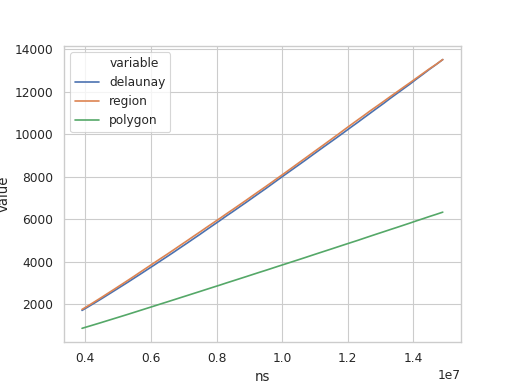

In [50]:
# df = pd.DataFrame.from_records(records)
# There is a lot of noise, we smooth it out with a rolling average to see the trends better
df_means = df.groupby(['n']).mean()
df_r = df_means.rolling(20).mean()
df_r['ns'] = df_means.index
df_m = pd.melt(df_r, id_vars =['ns'], value_vars =['delaunay', 'region', 'polygon']) 
sns.lineplot(x='ns', y='value', hue='variable', data=df_m)


<IPython.core.display.Javascript object>


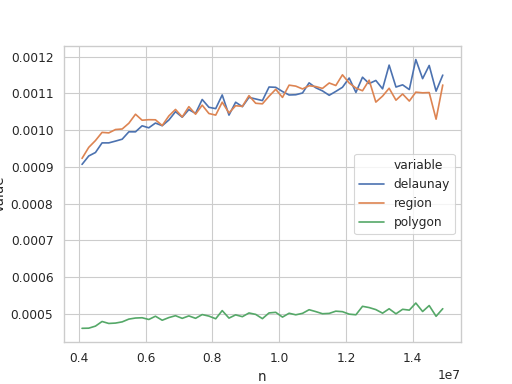

In [51]:
df_means = df_r
df_diff = df_means.diff()
df_diff['polygon']  / df_diff['ns']
numerator = df_diff[['delaunay', 'region', 'polygon']].values
denominator = df_diff['ns'].values
data = numerator / denominator[:,None]
data = np.concatenate((data, df_means.ns.values[:,None]), axis=1)
df1 = pd.DataFrame(data=data, columns=['delaunay', 'region', 'polygon', 'n'])
df1_m = pd.melt(df1, id_vars =['n'], value_vars =['delaunay', 'region', 'polygon']) 
sns.lineplot(x='n', y='value', hue='variable', data=df1_m)